In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [3]:
torch.normal?

Docstring:
normal(mean, std, *, generator=None, out=None) -> Tensor

Returns a tensor of random numbers drawn from separate normal distributions
whose mean and standard deviation are given.

The :attr:`mean` is a tensor with the mean of
each output element's normal distribution

The :attr:`std` is a tensor with the standard deviation of
each output element's normal distribution

The shapes of :attr:`mean` and :attr:`std` don't need to match, but the
total number of elements in each tensor need to be the same.

.. note:: When the shapes do not match, the shape of :attr:`mean`
          is used as the shape for the returned output tensor

.. note:: When :attr:`std` is a CUDA tensor, this function synchronizes
          its device with the CPU.

Args:
    mean (Tensor): the tensor of per-element means
    std (Tensor): the tensor of per-element standard deviations

Keyword args:
    generator (:class:`torch.Generator`, optional): a pseudorandom number generator for sampling
    out (Tenso

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [7]:
true_w.shape, features.shape, labels.shape

(torch.Size([2]), torch.Size([1000, 2]), torch.Size([1000, 1]))

In [5]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.6193, 1.4001]) 
label: tensor([0.6847])


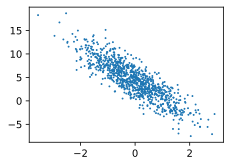

In [6]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [15]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.7856,  0.9741],
        [-1.7308,  1.4091],
        [-0.2126, -1.0966],
        [ 0.4161,  0.3757],
        [ 0.0566,  0.3585],
        [-0.4294, -1.1328],
        [-0.0070,  0.2116],
        [-1.0678, -0.0697],
        [ 0.4000, -0.7490],
        [-0.3489, -0.5608]]) 
 tensor([[ 2.4569],
        [-4.0473],
        [ 7.5038],
        [ 3.7459],
        [ 3.0972],
        [ 7.2080],
        [ 3.4842],
        [ 2.2982],
        [ 7.5420],
        [ 5.4003]])


In [23]:
#w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
w = torch.zeros(size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[0.],
         [0.]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [18]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [19]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [20]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [24]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.026424
epoch 2, loss 0.000090
epoch 3, loss 0.000049


In [22]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0002, -0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0003], grad_fn=<RsubBackward1>)


In [25]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [31]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter1 = load_array((features, labels), batch_size)

In [28]:
t = torch.rand(4)
t, *t

(tensor([0.0730, 0.6590, 0.5896, 0.9499]),
 tensor(0.0730),
 tensor(0.6590),
 tensor(0.5896),
 tensor(0.9499))

In [32]:
next(iter(data_iter1))

[tensor([[ 0.6405, -0.0514],
         [-1.2014,  1.5294],
         [ 0.6459,  0.4437],
         [ 0.7047,  1.5192],
         [ 0.2679, -1.4992],
         [-0.6593,  0.5147],
         [ 0.4829,  0.8323],
         [-1.7053,  1.9874],
         [-0.5595, -0.4932],
         [-1.1238, -1.3381]]),
 tensor([[ 5.6806],
         [-3.4052],
         [ 3.9913],
         [ 0.4459],
         [ 9.8304],
         [ 1.1347],
         [ 2.3222],
         [-5.9689],
         [ 4.7520],
         [ 6.4994]])]

In [33]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [34]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [35]:
loss = nn.MSELoss()

In [36]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [38]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter1:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000310
epoch 2, loss 0.000100
epoch 3, loss 0.000100


In [39]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0004, -0.0003])
b的估计误差： tensor([0.0003])


In [41]:
true_w.shape

torch.Size([2])